# Deep Learning & Art: Neural Style Transfer

In this assignment, you will learn about Neural Style Transfer. This algorithm was created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

**In this assignment, you will:**
- Implement the neural style transfer algorithm 
- Generate novel artistic images using your algorithm 

Most of the algorithms you've studied optimize a cost function to get a set of parameter values. In Neural Style Transfer, you'll optimize a cost function to get pixel values!

In [1]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import torch.nn as nn
import numpy as np
import torch.optim as optim
# get pre-trained vision models from pytorch repo
import torchvision.models as models
import matplotlib.pyplot as plt
from nst_utils import *
import imageio
%reload_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=200)

## 1 - Problem Statement

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. As seen below, it merges two images, namely: a **"content" image (C) and a "style" image (S), to create a "generated" image (G**). 

The generated image G combines the "content" of the image C with the "style" of image S. 

In this example, you are going to generate an image of the Louvre museum in Paris (content image C), mixed with a painting by Claude Monet, a leader of the impressionist movement (style image S).
<img src="images/louvre_generated.png" style="width:750px;height:200px;">

Let's see how you can do this. 

## 2 - Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

Following the [original NST paper](https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

I'll now setup the pretrained VGG-19 model from the pytorch repo.

In [ ]:
# Getting the pretrained batch-normalised vgg-19 model weights
model = models.vgg19_bn(pretrained=True, progress=True)

In [ ]:
print(model)

For the pre-trained model to work, we have to do some pre-processing. 

Following from PyTorch Docs.
> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

In [2]:
class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.69
    MEANS = np.array([0.485, 0.456, 0.406]).reshape((1,1,1,3))
    STYLE_IMAGE = 'images/stone_style.jpg' # Style image to use.
    CONTENT_IMAGE = 'images/cat.jpg' # Content image to use.
    OUTPUT_DIR = 'output/'
    
def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """
    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))
    # Substract the mean to match the expected input of VGG16
    image = image - CONFIG.MEANS
    # Tranpose image to match the PyTorch format: N, C, H, W
    image = np.transpose(image, (0, 3, 1, 2))
    return image

Where,
- Style Image --> ![](images/stone_style.jpg)
- Content Image --> ![](images/cat.jpg)

(1, 3, 225, 300)


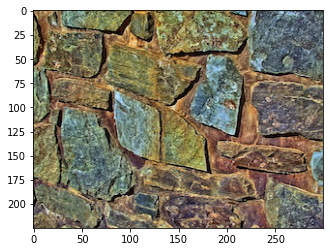

In [3]:
style_img = imageio.imread(CONFIG.STYLE_IMAGE)
plt.imshow(style_img)
print(reshape_and_normalize_image(style_img).shape) # dims of reshaped image

## 3 - Neural Style Transfer (NST)

We will build the Neural Style Transfer (NST) algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 - Computing the content cost

In our running example, the content image C will be the picture of the Louvre Museum in Paris. Run the code below to see a picture of the Louvre.

(600, 800, 3)

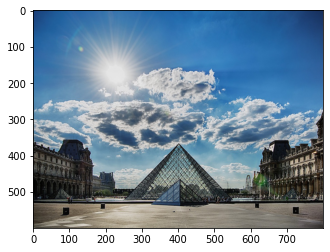

In [4]:
content_img = imageio.imread('images/louvre.jpg')
plt.imshow(content_img)
content_img.shape

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.

**3.1.1 - Make generated image G match the content of image C**

#### Shallower versus deeper layers
* The shallower layers of a ConvNet tend to detect lower-level features such as edges and simple textures.
* The deeper layers tend to detect higher-level features such as more complex textures as well as object classes. 

#### Choose a "middle" activation layer $a^{[l]}$
We would like the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. 
* In practice, you'll get the most visually pleasing results if you choose a layer in the **middle** of the network--neither too shallow nor too deep. 
* (After you have finished this exercise, feel free to come back and experiment with using different layers, to see how the results vary.)

#### Forward propagate image "C"
* Set the image C as the input to the pretrained VGG network, and run forward propagation.  
* Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. (In lecture, we had written this as $a^{[l](C)}$, but here we'll drop the superscript $[l]$ to simplify the notation.) This will be an $n_H \times n_W \times n_C$ tensor.

#### Forward propagate image "G"
* Repeat this process with the image G: Set G as the input, and run forward progation. 
* Let $a^{(G)}$ be the corresponding hidden layer activation. 

#### Content Cost Function $J_{content}(C,G)$
We will define the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. 
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below.
* Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style cost $J_{style}$.

<img src="images/NST_LOSS.png" style="width:800px;height:400px;">

**Exercise:** Compute the "content cost" using PyTorch. 

**Instructions**: The 3 steps to implement this function are:
1. Retrieve dimensions from `a_G`: 
2. Unroll `a_C` and `a_G` as explained in the picture above
3. Compute the content cost:
    
    

In [5]:
# GRADED FUNCTION: compute_content_cost
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.shape
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = a_C.view(n_C, -1) # output of dims: n_C X (n_H x n_W)
    a_G_unrolled = a_G.view(n_C, -1) # output of dims: n_C X (n_H x n_W)
    # compute the cost with tensorflow (≈1 line)
    J_content = torch.mean((a_C_unrolled-a_G_unrolled)**2)/4 # seeing similarity accross activations of content and style image
    ### END CODE HERE ###
    
    return J_content

In [6]:
torch.manual_seed(1)
a_C = torch.normal(1, 4, size=(1, 4, 4, 3))
a_G = torch.normal(1, 4, size=(1, 4, 4, 3))
J_content = compute_content_cost(a_C, a_G)
print(J_content)

tensor(8.4785)


#### What you should remember
- The content cost takes a hidden layer activation of the neural network, and measures how different $a^{(C)}$ and $a^{(G)}$ are. 
- When we minimize the content cost later, this will help make sure $G$ has similar content as $C$.

### 3.2 - Computing the style cost

For our running example, we will use the following style image: 

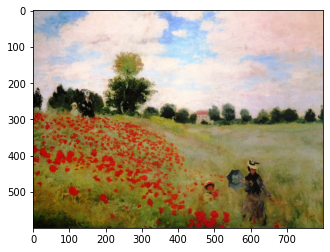

In [7]:
style_img = imageio.imread("images/monet_800600.jpg")
imshow(style_img)

The above is a painting of the impressionist style.

### 3.2.1 - Style matrix

#### Gram matrix
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

#### Two meanings of the variable $G$
* Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature. 
* $G$ is used to denote the Style matrix (or Gram matrix) 
* $G$ also denotes the generated image. 
* For this assignment, we will use $G_{gram}$ to refer to the Gram matrix, and $G$ to denote the generated image.


#### Compute $G_{gram}$
In Neural Style Transfer (NST), you can compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:

<img src="images/NST_GM.png" style="width:900px;height:300px;">

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)i,j}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),i,i}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

In [8]:
# GRADED FUNCTION: gram_matrix
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    ### START CODE HERE ### (≈1 line)
    GA =  torch.mm(A, A.t())
    ### END CODE HERE ###
    return GA

In [9]:
torch.manual_seed(1)
A = torch.normal(1, 4, size=(3, 2*1))
GA = gram_matrix(A)
print("Gram Matrix:\n", GA)

Gram Matrix:
 tensor([[17.5644, 11.7512, -2.2505],
        [11.7512, 13.7014,  0.1624],
        [-2.2505,  0.1624,  0.7648]])


### 3.2.2 - Style Cost
Your goal will be to minimize the distance between the Gram matrix of the "style" image S and the gram matrix of the "generated" image G. 
* For now, we are using only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* Remember, this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$

**Exercise**: Compute the style cost for a single layer. 

**Instructions**: The 3 steps to implement this function are:
1. Retrieve dimensions from the hidden layer activations a_G: 
2. Unroll the hidden layer activations a_S and a_G into 2D matrices, as explained in the picture above (see the images in the sections "computing the content cost" and "style matrix").
3. Compute the Style matrix of the images S and G. (Use the function you had previously written.) 
4. Compute the Style cost.

In [10]:
# GRADED FUNCTION: compute_layer_style_cost
def compute_layer_style_cost(a_S, a_G):
    """
    Compute the style cost for a single layer.
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.shape
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S_unrolled = a_S.view(n_C, -1)
    a_G_unrolled = a_G.view(n_C, -1)

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S_unrolled)
    GG = gram_matrix(a_G_unrolled)

    # Computing the loss (≈1 line)
    J_style_layer = torch.sum((GS-GG)**2)/(4*(n_C**2)*(n_H*n_W)**2)
    ### END CODE HERE ###
    
    return J_style_layer

In [11]:
torch.manual_seed(1)
a_S = torch.normal(1, 4, size=(1, 4, 4, 3))
a_G = torch.normal(1, 4, size=(1, 4, 4, 3))
J_style_layer = compute_layer_style_cost(a_S, a_G)
print("Cost of style layer:\n", J_style_layer)

Cost of style layer:
 tensor(7.2307)


### 3.2.3 Style Weights

* So far you have captured the style from only one layer. 
* We'll get better results if we "merge" style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$.
* By default, we'll give each layer equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

In [ ]:
model

In [82]:
# layer num mapped to weights contributing how much they affect generated image
STYLE_LAYER_DICT = {0:0.2, 5:0.2, 10:0.2, 19:0.2, 28:0.2}
# experimental variable below
exp1_style_layer_dict = {5:0.1, 10:0.2, 19:0.3, 21:0.2, 28:0.2}
exp2_style_layer_dict = {5:0.2, 10:0.3, 16:0.2, 21:0.1, 25:0.1}

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given as keys of the layers in `STYLE_LAYER_DICT`. 


### Exercise: compute style cost

* We've implemented a compute_style_cost(...) function. 
* It calls your `compute_layer_style_cost(...)` several times, and weights their results using the values in `STYLE_LAYERS`. 
* Please read over it to make sure you understand what it's doing. 

#### Description of `compute_style_cost`
For each layer:
* Select the activation (the output tensor) of the current layer.
* Get the style of the style image "S" from the current layer.
* Get the style of the generated image "G" from the current layer.
* Compute the "style cost" for the current layer
* Add the weighted style cost to the overall style cost (J_style)

Once you're done with the loop:  
* Return the overall style cost.

In [45]:
def compute_style_cost(style_layer_dict, gen_img_res, style_img_res):
    """
    Computes the overall style cost from several chosen layers
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python dict containing:
                        - the ids of the layers we would like to extract style from
                        - a coefficient for each of them
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    J_style = 0
    for layer_id, coeff in style_layer_dict.items():
        a_S = style_img_res[layer_id]
        a_G = gen_img_res[layer_id]
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style+=J_style_layer*coeff
    return J_style

**Note**: In the inner-loop of the for-loop above, `a_G` is a tensor and hasn't been evaluated yet. It will be evaluated and updated at each iteration when we run the TensorFlow graph in model_nn() below.

How do you choose the coefficients for each layer? The deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other. So if you want the generated image to softly follow the style image, try choosing larger weights for deeper layers and smaller weights for the first layers. In contrast, if you want the generated image to strongly follow the style image, try choosing smaller weights for deeper layers and larger weights for the first layers.

> See exp1_style_layer_dict / exp2_style_layer_dict

## What you should remember
- The style of an image can be represented using the Gram matrix of a hidden layer's activations. 
- We get even better results by combining this representation from multiple different layers. 
- This is in contrast to the content representation, where usually using just a single hidden layer is sufficient.
- Minimizing the style cost will cause the image $G$ to follow the style of the image $S$. 



### 3.3 - Defining the total cost to optimize
Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

**Exercise**: Implement the total cost function which includes both the content cost and the style cost. 

In [46]:
def get_costs(model, content_img_res, style_img_res, style_layer_dict, content_layer, generated_image):
    generated_img_res = model(generated_image)
    #Compute content cost
    a_C = content_img_res[content_layer]
    a_G = style_img_res[content_layer]
    J_content = compute_content_cost(a_C, a_G)
    J_style = compute_style_cost(style_layer_dict, generated_img_res, style_img_res)
    
    return J_content, J_style

In [47]:
# GRADED FUNCTION: total_cost
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    Returns:
    J -- total cost as defined by the formula above.
    """
    ### START CODE HERE ### (≈1 line)
    J = alpha*J_content + beta*J_style
    ### END CODE HERE ###
    return J


## What you should remember
- The total cost is a linear combination of the content cost $J_{content}(C,G)$ and the style cost $J_{style}(S,G)$.
- $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style.

## 4 - Solving the optimization problem
Finally, let's put everything together to implement Neural Style Transfer!




In [91]:
# Let's load, reshape, and normalize our "content" image (the Louvre museum picture):
content_image = imageio.imread("images/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)
print(content_image.shape)
# Let's load, reshape and normalize our "style" image
style_image = imageio.imread("images/starry.jpg")
style_image = reshape_and_normalize_image(style_image)
print(style_image.shape)

(1, 3, 300, 400)
(1, 3, 300, 400)


#### Generated image correlated with content image
Now, we initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. 

In [92]:
def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, CONFIG.COLOR_CHANNELS, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH)).astype('float32')
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image
#     print(noise_image.shapecontent_imageimage.shape)

Content Image Shape: (1, 3, 300, 400) 
Style Image Shape: (1, 3, 300, 400) 
Generated Image Shape: (1, 3, 300, 400)


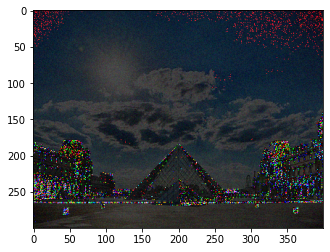

In [93]:
generated_image = generate_noise_image(content_image)
plt.imshow(np.transpose(generated_image, (0, 2, 3, 1))[0].astype(np.uint8))
print("Content Image Shape:", content_image.shape,"\nStyle Image Shape:", style_image.shape, "\nGenerated Image Shape:", generated_image.shape
     )

#### Load pre-trained VGG19 model
Next, as explained in part (2), let's load the VGG19 model.

In [94]:
# from furkanu's code
class VGG19_Style_Transfer_Model(nn.Module):
    def __init__(self, layers=[None]):
        super().__init__()
        self.layers = layers
        req_layers = max(layers) + 1 if max(layers) is not None else None
        features = list(models.vgg19(pretrained=True).features)[:req_layers]
        self.features = nn.ModuleList(features).eval()
        
    def forward(self, x):
        results = {}
        for i, module in enumerate(self.features):
            x = module(x)
            if i in self.layers:
                results[i] = x
        return results

In [95]:
content_layer = 21
model = VGG19_Style_Transfer_Model(layers=[*STYLE_LAYER_DICT] + [content_layer])
content_image_tensor = torch.tensor(content_image).float().to(device)
style_image_tensor = torch.tensor(style_image).float().to(device)
generated_image_tensor = torch.tensor(generated_image).float().to(device)
model = model.to(device)

In [96]:
optimizer = optim.Adam([generated_image_tensor.requires_grad_()], lr=2.0)

In [97]:
content_img_res = model(content_image_tensor)
style_img_res = model(style_image_tensor)

In [98]:
for layer in content_img_res.keys():
    content_img_res[layer] = content_img_res[layer].detach()
    style_img_res[layer] = style_img_res[layer].detach()

In [99]:
content_layer = 21
params = {
    'model': model,
    'style_layers_dict': exp1_style_layer_dict,
    'content_layer': content_layer,
    'generated_image_tensor': generated_image_tensor,
    'content_img_res': content_img_res,
    'style_img_res': style_img_res
}

In [100]:
def train(model, style_layers_dict, content_layer, generated_image_tensor, content_img_res, style_img_res, epochs=200):
    for i in range(epochs):
        # Print every 20 iteration.
        Jc, Js = get_costs(model, content_img_res, style_img_res, style_layers_dict, content_layer, generated_image_tensor)
        optimizer.zero_grad()
        Jt = total_cost(Jc, Js)
        Jt.backward()
        optimizer.step()
        if i%50 == 0:
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt.item()))
            print("content cost = " + str(Jc.item()))
            print("style cost = " + str(Js.item()))
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + "_2.png", generated_image_tensor)
    # save last generated image
    save_image('output/generated_image.jpg', generated_image_tensor)

In [101]:
def save_image(path, image):
    # Un-normalize the image so that it looks good
    image = image.detach().cpu().numpy().transpose(0, 2, 3, 1)
    image += CONFIG.MEANS
    image = np.clip(image[0], 0, 255).astype('uint8')
    
    imageio.imsave(path, image)

In [102]:
train(**params, epochs=200)

Iteration 0 :
total cost = 201428512.0
content cost = 2507.704345703125
style cost = 5035086.0
Iteration 50 :
total cost = 9845403.0
content cost = 2507.704345703125
style cost = 245508.15625
Iteration 100 :
total cost = 4538249.0
content cost = 2507.704345703125
style cost = 112829.296875
Iteration 150 :
total cost = 3215493.25
content cost = 2507.704345703125
style cost = 79760.40625


## Final Gen Image
![images/generated_image.jpg](output/generated_image.jpg)